In [0]:
# Importing Libraries

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
cd ./drive

/content/drive


In [5]:
cd ./My Drive

/content/drive/My Drive


In [7]:
cd ./HumanActivityRecognition/HAR 

/content/drive/My Drive/HumanActivityRecognition/HAR


In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = './UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = ('UCI_HAR_Dataset/{0}/Inertial Signals/{1}_{2}.txt'.format(subset,signal,subset))
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = "./UCI_HAR_Dataset/{0}/y_{1}.txt".format(subset,subset)
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [19]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 20
n_hidden = 30

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [24]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
epochs = 30
batch_size = 50
n_hidden = 35

In [30]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.9))
#model.add(Dense(n_classes, activation='sigmoid'))
model.add(LSTM(n_hidden))

model.add(Dropout(0.9))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 35)           6300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 35)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dropout_6 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 216       
Total params: 16,456
Trainable params: 16,456
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
scores = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.2886 - acc: 0.4611 - val_loss: 1.0531 - val_acc: 0.6101
Epoch 2/30
7352/7352 [==============================] - 67s 9ms/step - loss: 1.1826 - acc: 0.4974 - val_loss: 0.9975 - val_acc: 0.5507
Epoch 3/30
7352/7352 [==============================] - 67s 9ms/step - loss: 1.0974 - acc: 0.5010 - val_loss: 0.8613 - val_acc: 0.6244
Epoch 4/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.0554 - acc: 0.5131 - val_loss: 0.8336 - val_acc: 0.6301
Epoch 5/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.0165 - acc: 0.5135 - val_loss: 0.8456 - val_acc: 0.5921
Epoch 6/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.9994 - acc: 0.5126 - val_loss: 0.7886 - val_acc: 0.5843
Epoch 7/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.9822 - acc: 0.5231 - val_loss: 0.8081 - val_acc: 0.6077
Epoch 8

In [0]:
import matplotlib.pyplot as plt
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x,vy,'b',label="Validation Loss")
    ax.plot(x,ty,'r',label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Test score: 0.9084643532471774
Test accuracy: 0.5659993213437394


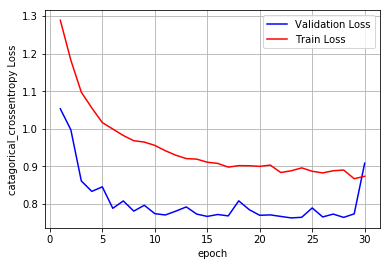

In [36]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
x = list(range(1,31))
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('catagorical_crossentropy Loss')
vy = scores.history['val_loss']
ty = scores.history['loss']
plt_dynamic(x, vy, ty, ax)

- By observing above plot we can say that this model is overfitting.

In [0]:
epochs = 60
batch_size = 100
n_hidden = 30

In [44]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
#model.add(Dropout(0.9))
#model.add(Dense(n_classes, activation='sigmoid'))
model.add(LSTM(n_hidden))

model.add(Dropout(0.9))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 30)           4800      
_________________________________________________________________
lstm_12 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [46]:
scores = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/60
7352/7352 [==============================] - 36s 5ms/step - loss: 1.6467 - acc: 0.2976 - val_loss: 1.4177 - val_acc: 0.4706
Epoch 2/60
7352/7352 [==============================] - 34s 5ms/step - loss: 1.4883 - acc: 0.3783 - val_loss: 1.3158 - val_acc: 0.4520
Epoch 3/60
7352/7352 [==============================] - 34s 5ms/step - loss: 1.4018 - acc: 0.4242 - val_loss: 1.2281 - val_acc: 0.5127
Epoch 4/60
7352/7352 [==============================] - 34s 5ms/step - loss: 1.3329 - acc: 0.4433 - val_loss: 1.1463 - val_acc: 0.5473
Epoch 5/60
7352/7352 [==============================] - 34s 5ms/step - loss: 1.2556 - acc: 0.4703 - val_loss: 1.0372 - val_acc: 0.6668
Epoch 6/60
7352/7352 [==============================] - 34s 5ms/step - loss: 1.2069 - acc: 0.4845 - val_loss: 0.9930 - val_acc: 0.6919
Epoch 7/60
7352/7352 [==============================] - 34s 5ms/step - loss: 1.1640 - acc: 0.4963 - val_loss: 0.9236 - val_acc: 0.5772
Epoch 8

Test score: 0.7264316521299302
Test accuracy: 0.49915167968435775


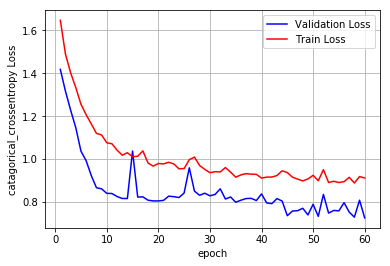

In [48]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
x = list(range(1,61))
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('catagorical_crossentropy Loss')
vy = scores.history['val_loss']
ty = scores.history['loss']
plt_dynamic(x, vy, ty, ax)

- By observing above plot this model is not overfitting but had seen very less accuracy

In [0]:
epochs = 30
batch_size = 16
n_hidden = 32

In [72]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(2))
#model.add(Dense(n_classes, activation='sigmoid'))
model.add(LSTM(n_hidden))

model.add(Dropout(2))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_18 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [74]:
scores = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 216s 29ms/step - loss: 1.0363 - acc: 0.5443 - val_loss: 0.8359 - val_acc: 0.6447
Epoch 2/30
7352/7352 [==============================] - 214s 29ms/step - loss: 0.7027 - acc: 0.6591 - val_loss: 0.7232 - val_acc: 0.6973
Epoch 3/30
7352/7352 [==============================] - 218s 30ms/step - loss: 0.6102 - acc: 0.7206 - val_loss: 0.6119 - val_acc: 0.7027
Epoch 4/30
7352/7352 [==============================] - 214s 29ms/step - loss: 0.4963 - acc: 0.7626 - val_loss: 0.5024 - val_acc: 0.7679
Epoch 5/30
7352/7352 [==============================] - 213s 29ms/step - loss: 0.3396 - acc: 0.8897 - val_loss: 0.3697 - val_acc: 0.8690
Epoch 6/30
7352/7352 [==============================] - 214s 29ms/step - loss: 0.2400 - acc: 0.9229 - val_loss: 0.4196 - val_acc: 0.8751
Epoch 7/30
7352/7352 [==============================] - 214s 29ms/step - loss: 0.1932 - acc: 0.9343 - val_loss: 0.2455 - val_acc: 

Test score: 0.4347589199567052
Test accuracy: 0.8961655921275874


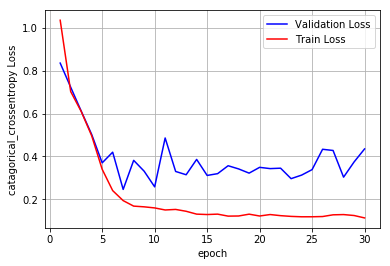

In [75]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
x = list(range(1,31))
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('catagorical_crossentropy Loss')
vy = scores.history['val_loss']
ty = scores.history['loss']
plt_dynamic(x, vy, ty, ax)

- By observaing above plot we can clearly see that this model is overfotting.

In [76]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  1      398        92        0                   0   
STANDING                 0      104       428        0                   0   
WALKING                  0        0         9      477                   6   
WALKING_DOWNSTAIRS       0        0         0        1                 404   
WALKING_UPSTAIRS         0        5         1       41                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            4  
WALKING_DOWNSTAIRS                15  
WALKING_UPSTAIRS                 424  


In [77]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 16s 5ms/step


In [78]:
score

[0.4347589199567052, 0.8961655921275874]

In [0]:
epochs = 30
batch_size = 20
n_hidden = 30

In [83]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(rate = 0.5))
#model.add(Dense(n_classes, activation='sigmoid'))
model.add(LSTM(n_hidden))

model.add(Dropout(rate = 1))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128, 30)           4800      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128, 30)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_25 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [86]:
scores = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 177s 24ms/step - loss: 1.1941 - acc: 0.4981 - val_loss: 1.0242 - val_acc: 0.5517
Epoch 2/30
7352/7352 [==============================] - 173s 24ms/step - loss: 0.8062 - acc: 0.6167 - val_loss: 0.8645 - val_acc: 0.6040
Epoch 3/30
7352/7352 [==============================] - 173s 24ms/step - loss: 0.6914 - acc: 0.6678 - val_loss: 0.7260 - val_acc: 0.6709
Epoch 4/30
7352/7352 [==============================] - 173s 24ms/step - loss: 0.6386 - acc: 0.7054 - val_loss: 0.7143 - val_acc: 0.6837
Epoch 5/30
7352/7352 [==============================] - 174s 24ms/step - loss: 0.5533 - acc: 0.7539 - val_loss: 0.6090 - val_acc: 0.7428
Epoch 6/30
7352/7352 [==============================] - 173s 24ms/step - loss: 0.4984 - acc: 0.7700 - val_loss: 0.6686 - val_acc: 0.7173
Epoch 7/30
7352/7352 [==============================] - 172s 23ms/step - loss: 0.4407 - acc: 0.8157 - val_loss: 0.5480 - val_acc: 

Test score: 0.31878662802921154
Test accuracy: 0.8717339667458432


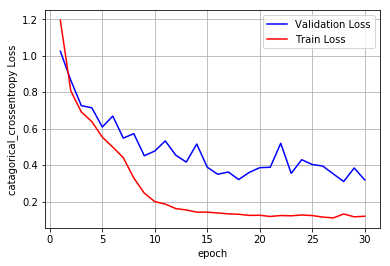

In [87]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
x = list(range(1,31))
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('catagorical_crossentropy Loss')
vy = scores.history['val_loss']
ty = scores.history['loss']
plt_dynamic(x, vy, ty, ax)

- we can clerarly see that this model is overfitting.

In [0]:
epochs = 40
batch_size = 50
n_hidden = 33

In [93]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(rate = 0.5))
#model.add(Dense(n_classes, activation='sigmoid'))
model.add(LSTM(n_hidden))

model.add(Dropout(rate = 0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 128, 33)           5676      
_________________________________________________________________
dropout_28 (Dropout)         (None, 128, 33)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 33)                8844      
_________________________________________________________________
dropout_29 (Dropout)         (None, 33)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 204       
Total params: 14,724
Trainable params: 14,724
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [95]:
scores = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 74s 10ms/step - loss: 1.3598 - acc: 0.4207 - val_loss: 1.2746 - val_acc: 0.4024
Epoch 2/40
7352/7352 [==============================] - 70s 10ms/step - loss: 1.0500 - acc: 0.5590 - val_loss: 1.3598 - val_acc: 0.4136
Epoch 3/40
7352/7352 [==============================] - 69s 9ms/step - loss: 0.8502 - acc: 0.6186 - val_loss: 0.8039 - val_acc: 0.6043
Epoch 4/40
7352/7352 [==============================] - 70s 9ms/step - loss: 0.8339 - acc: 0.6145 - val_loss: 0.9337 - val_acc: 0.5182
Epoch 5/40
7352/7352 [==============================] - 70s 10ms/step - loss: 0.7486 - acc: 0.6342 - val_loss: 0.7737 - val_acc: 0.5881
Epoch 6/40
7352/7352 [==============================] - 70s 9ms/step - loss: 0.6864 - acc: 0.6620 - val_loss: 0.6909 - val_acc: 0.6162
Epoch 7/40
7352/7352 [==============================] - 69s 9ms/step - loss: 0.6444 - acc: 0.6835 - val_loss: 0.6851 - val_acc: 0.6155
Epoc

Test score: 0.3519003335333593
Test accuracy: 0.9148286392941974


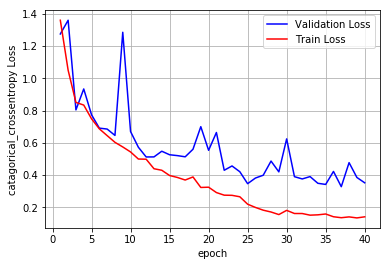

In [96]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
x = list(range(1,41))
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('catagorical_crossentropy Loss')
vy = scores.history['val_loss']
ty = scores.history['loss']
plt_dynamic(x, vy, ty, ax)

In [97]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      419        69        1                   0   
STANDING                 0      110       421        1                   0   
WALKING                  0        0         0      472                   7   
WALKING_DOWNSTAIRS       0        0         0        0                 411   
WALKING_UPSTAIRS         0        0         0        1                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           17  
WALKING_DOWNSTAIRS                 9  
WALKING_UPSTAIRS                 463  


- by observing above plot With a simple 2 layer LSTM architecture is seen to be not overfitting with 91.48% accuracy.